In [1]:
import csv
import os
import pickle
import sys
import copy

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append("../tools/")
# sys.path.append("../dataset/")
sys.path.append("../data_wrangling/")

from data_explorer import explorer
from feature_format import featureFormat, targetFeatureSplit

%matplotlib inline


<h2>Question 1</h2>

>Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those? [Relevant rubric items: “data exploration”, “outlier investigation”]


<h2>Setting up data for analysis</h2>

In [2]:
data_dict = {}
dataset = '../dataset/final_project_dataset.pkl'

#--- extract dictionary from dataset:
with open(dataset, 'rb') as data_file:
    data_dict = pickle.load(data_file)


<h3>Write dataset to csv file:</h3>

In [3]:
def convert_to_csv(data_dict, excluded_features = []):
    #--- Save dataset as CSV

    # Create ouput directory if it doesn't already exist:
    outdirname = '../output'
    try:
        os.makedirs(outdirname)
        print('\nDirectory "{}" created'.format(outdirname))
    except FileExistsError:
        print('\nDirectory "{}" already exists - nothing done.'.format(outdirname))

    csvfilename = outdirname + '/enron_data.csv'

    with open(csvfilename, 'w') as csv_file:
        print('\nWriting data set to ../{}'.format(csvfilename))
        writer = csv.writer(csv_file)

        #--- create header:
        header_line = ['Name']

        for name in data_dict.keys():
            if name != 'TOTAL':
                value_pairs = data_dict[name]

                for feature_value in value_pairs.keys():
                    if feature_value not in excluded_features:
                        header_line.append(feature_value)

                break

        writer.writerow(header_line)

        for name in data_dict.keys():
            line = []
            line.append(name)

            for k, v in data_dict[name].items():
                if k not in excluded_features:
                    line.append(v)

            writer.writerow(line)

In [4]:
convert_to_csv(data_dict)


Directory "../output" already exists - nothing done.

Writing data set to ../../output/enron_data.csv


<h2>Data Exploration</h2>
<h3>Summary of information contained in the dataset:</h3>

In [5]:

#--- explore data:
explore_obj = explorer(data_dict)

def repeat_to_length(string_to_expand, length):
    return (string_to_expand * (int(length/len(string_to_expand))+1))[:length]

parameters = explore_obj.get_dataset_parameters()
for k,v in parameters.items():
    if k != 'Features with NaN':
        l = 45 - len(k)
        dots = repeat_to_length('.', l)
        print('\t{0}: {1} {2}'.format(k, dots, v))


/home/dan/Dokumente/nanodegree/p4/main/../data_wrangling/data_explorer.py:66: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.enron_df = self.enron_df.replace('NaN', pd.np.nan)
METTS MARK              0.0
BAXTER JOHN C           0.0
ELLIOTT STEVEN          0.0
CORDES WILLIAM R        0.0
HANNON KEVIN P          0.0
                       ... 
GRAMM WENDY L           0.0
CAUSEY RICHARD A        0.0
TAYLOR MITCHELL S       0.0
DONAHUE JR JEFFREY M    0.0
GLISAN JR BEN F         0.0
Length: 146, dtype: float64
	Number of individuals: ........................ 146
	Names: ........................................ ['METTS MARK', 'BAXTER JOHN C', 'ELLIOTT STEVEN', 'CORDES WILLIAM R', 'HANNON KEVIN P', 'MORDAUNT KRISTINA M', 'MEYER ROCKFORD G', 'MCMAHON JEFFREY', 'HAEDICKE MARK E', 'PIPER GREGORY F', 'HUMPHREY GENE E', 'NOLES JAMES L', 'BLACHMAN JEREMY M', 'SUNDE MARTIN', 'GIBBS DANA R', 'LOWRY CHARLES P

<h3>Dataset statistical information:</h3>

In [6]:
# Create dataframe from Enron data_dict:
enron_df = explore_obj.get_dataframe()
enron_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, METTS MARK to GLISAN JR BEN F
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   salary                     95 non-null     float64
 1   to_messages                86 non-null     float64
 2   deferral_payments          39 non-null     float64
 3   total_payments             125 non-null    float64
 4   loan_advances              4 non-null      float64
 5   bonus                      82 non-null     float64
 6   email_address              111 non-null    object 
 7   restricted_stock_deferred  18 non-null     float64
 8   deferred_income            49 non-null     float64
 9   total_stock_value          126 non-null    float64
 10  expenses                   95 non-null     float64
 11  from_poi_to_this_person    86 non-null     float64
 12  exercised_stock_options    102 non-null    float64
 13  from_messages              86 non-

<h3>Example of data content for POI Kenneth Lay:</h3>

In [7]:
sample_contents = data_dict['LAY KENNETH L']
for k, v in sample_contents.items():
    l = 45 - len(k)
    dots = repeat_to_length('.', l)
    print('\t{0}: {1} {2}'.format(k, dots, v))

	salary: ....................................... 1072321
	to_messages: .................................. 4273
	deferral_payments: ............................ 202911
	total_payments: ............................... 103559793
	loan_advances: ................................ 81525000
	bonus: ........................................ 7000000
	email_address: ................................ kenneth.lay@enron.com
	restricted_stock_deferred: .................... NaN
	deferred_income: .............................. -300000
	total_stock_value: ............................ 49110078
	expenses: ..................................... 99832
	from_poi_to_this_person: ...................... 123
	exercised_stock_options: ...................... 34348384
	from_messages: ................................ 36
	other: ........................................ 10359729
	from_this_person_to_poi: ...................... 16
	poi: .......................................... True
	long_term_incentive: ................

<h3>Ratio of NaN entries per feature in dataset:</h3>

In [9]:
features_nan_counts = explore_obj.get_feature_nan_counts()
df_features_nan_counts = pd.DataFrame(features_nan_counts.items())
df_features_nan_counts.columns = ['Feature','NaN count']
df_features_nan_counts.sort_values(by=['NaN count'], inplace=True)
df_features_nan_counts.reset_index(drop=True, inplace=True)

max_nan_count = df_features_nan_counts.iloc[len(df_features_nan_counts)-1]['NaN count']
print('\nMax NaN count: {}'.format(max_nan_count))
df_features_nan_counts['ratio'] = df_features_nan_counts['NaN count']/max_nan_count
print(df_features_nan_counts.to_string(index=False))

#--- list features with more than selected percentage (%) NaNs:
thresh_ratio = 0.7
rslt_df = df_features_nan_counts.loc[df_features_nan_counts['ratio'] > thresh_ratio]
nan_features = rslt_df['Feature'].tolist()
print('\nFeatures with NaN > {} % will be excluded:'.format(thresh_ratio*100.0))
print(nan_features)

selected_features = []
all_features = explore_obj.get_features()

for feature in all_features:
    if feature not in nan_features:
        selected_features.append(feature)

print('\nselected features:\n{}'.format(selected_features))


Max NaN count: 142
                  Feature  NaN count    ratio
                     Name          0 0.000000
                      poi          0 0.000000
        total_stock_value         20 0.140845
           total_payments         21 0.147887
            email_address         35 0.246479
         restricted_stock         36 0.253521
  exercised_stock_options         44 0.309859
                   salary         51 0.359155
                 expenses         51 0.359155
                    other         53 0.373239
  from_poi_to_this_person         60 0.422535
            from_messages         60 0.422535
  from_this_person_to_poi         60 0.422535
  shared_receipt_with_poi         60 0.422535
              to_messages         60 0.422535
                    bonus         64 0.450704
      long_term_incentive         80 0.563380
          deferred_income         97 0.683099
        deferral_payments        107 0.753521
restricted_stock_deferred        128 0.901408
            di

<h3>NaN entries per employee in dataset:</h3>

In [10]:
df_employee_nan_counts = ((enron_df[all_features].isna()).sum(axis=1)).to_frame()
df_employee_nan_counts['Name'] = df_employee_nan_counts.index
df_employee_nan_counts.columns = ['NaN count', 'Name']
df_employee_nan_counts = df_employee_nan_counts[['Name', 'NaN count']]
df_employee_nan_counts['NaN %'] = (df_employee_nan_counts['NaN count'] / len(all_features))*100.
df_employee_nan_counts.sort_values(by=['NaN count'], inplace=True)
df_employee_nan_counts.reset_index(drop=True, inplace=True)
df_employee_nan_counts

,Name,NaN count,NaN %
0,LAY KENNETH L,2,9.090909
1,FREVERT MARK A,2,9.090909
2,HAEDICKE MARK E,2,9.090909
3,ALLEN PHILLIP K,2,9.090909
4,DERRICK JR. JAMES V,3,13.636364
...,...,...,...
141,WROBEL BRUCE,18,81.818182
142,WHALEY DAVID A,18,81.818182
143,GRAMM WENDY L,18,81.818182
144,THE TRAVEL AGENCY IN THE PARK,18,81.818182


In [11]:
#--- Remove employees with NaN count > 90%
empl_to_pop = df_employee_nan_counts.loc[df_employee_nan_counts['NaN %'] >90. , 'Name'].tolist()

size_empl_to_pop = len(empl_to_pop)

if size_empl_to_pop > 1:
    print('\nThe following employees have more than 90% NaN entries and will be ignored if non-POI:')
    print(empl_to_pop)
elif size_empl_to_pop == 1:
    print('\nThe following employee has more than 90% NaN entries and will be ignored if non-POI:')
    print(empl_to_pop[0])
else:
    pass

poi_list = explore_obj.get_poi_list()

for empl in empl_to_pop:
    if empl not in poi_list:
        data_dict.pop(empl, 0)

#--- remove 'TOTAL' point:
print('\nAlso "TOTAL" entry removed from data_dict')
data_dict.pop('TOTAL', 0) 



The following employee has more than 90% NaN entries and will be ignored if non-POI:
LOCKHART EUGENE E

Also "TOTAL" entry removed from data_dict


{'salary': 26704229,
 'to_messages': 'NaN',
 'deferral_payments': 32083396,
 'total_payments': 309886585,
 'loan_advances': 83925000,
 'bonus': 97343619,
 'email_address': 'NaN',
 'restricted_stock_deferred': -7576788,
 'deferred_income': -27992891,
 'total_stock_value': 434509511,
 'expenses': 5235198,
 'from_poi_to_this_person': 'NaN',
 'exercised_stock_options': 311764000,
 'from_messages': 'NaN',
 'other': 42667589,
 'from_this_person_to_poi': 'NaN',
 'poi': False,
 'long_term_incentive': 48521928,
 'shared_receipt_with_poi': 'NaN',
 'restricted_stock': 130322299,
 'director_fees': 1398517}

In [12]:
#--- Remove features with NaN above threshhold from the dataset:

def clean_features(dict, features_to_exclude):
    clean_dict = {}
    
    for k, v in dict.items():
        value_pair = v

        inner_dict = {}
        for k1, v1 in value_pair.items():
            if k1 not in features_to_exclude:
                inner_dict[k1] = v1

        clean_dict[k] = copy.deepcopy(inner_dict)

    return clean_dict

data_dict = clean_features(data_dict, nan_features)

In [18]:
sample_contents = data_dict['BHATNAGAR SANJAY']
for k, v in sample_contents.items():
    l = 45 - len(k)
    dots = repeat_to_length('.', l)
    print('\t{0}: {1} {2}'.format(k, dots, v))

	salary: ....................................... NaN
	to_messages: .................................. 523
	total_stock_value: ............................ NaN
	total_payments: ............................... 15456290
	bonus: ........................................ NaN
	email_address: ................................ sanjay.bhatnagar@enron.com
	deferred_income: .............................. NaN
	expenses: ..................................... NaN
	from_poi_to_this_person: ...................... 0
	exercised_stock_options: ...................... 2604490
	from_messages: ................................ 29
	other: ........................................ 137864
	from_this_person_to_poi: ...................... 1
	poi: .......................................... False
	long_term_incentive: .......................... NaN
	shared_receipt_with_poi: ...................... 463
	restricted_stock: ............................. -2604490


In [30]:
enron_df = (pd.DataFrame.from_dict(data_dict)).T
enron_df.replace('NaN', pd.np.nan, inplace=True)
# enron_df


<ipython-input-30-f70f85148cb8>:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  enron_df.replace('NaN', pd.np.nan, inplace=True)


In [29]:
#--- Ref.: https://www.shanelynn.ie/pandas-iloc-loc-select-rows-and-columns-dataframe/
#enron_df.loc['BHATNAGAR SANJAY']

In [14]:
#--- create dataframe from updated dictionary dataset:
convert_to_csv(data_dict)


Directory "../output" already exists - nothing done.

Writing data set to ../../output/enron_data.csv


In [39]:
#--- further explore the new dataset by looking into each feature:

#--- Money related features:
financial_features = ['salary', 'total_payments', 'bonus', 'deferred_income', 'total_stock_value', 
    'expenses', 'exercised_stock_options', 'long_term_incentive', 'restricted_stock']

#--- Email related features:
email_features = ['from_poi_to_this_person','from_this_person_to_poi','from_messages',
    'shared_receipt_with_poi','to_messages']


In [36]:
def sns_boxplot(df, title, features, n, m):
    '''
    Create grid boxplot
    - df = dataframe
    - title = plot title
    - features = list of features to consider
    - n = number of rows for grid plot
    - m = number of columns for grid plot
    '''
    #--- Ref: https://www.geeksforgeeks.org/multi-plot-grid-in-seaborn/
    n = 2
    m = 3

    fig, axes = plt.subplots(n, m, figsize=(24, 10))
    fig.suptitle(title)

    k = 0
    for i in range(n):
        for j in range(m):
            feature = features[k]
            (pd.to_numeric(df[feature]).groupby(df['poi'])).mean()
            sns.boxplot(ax=axes[i, j], data=df, x='poi', y=feature)
            if (k+1) < len(features):
                k+=1
            else:
                break

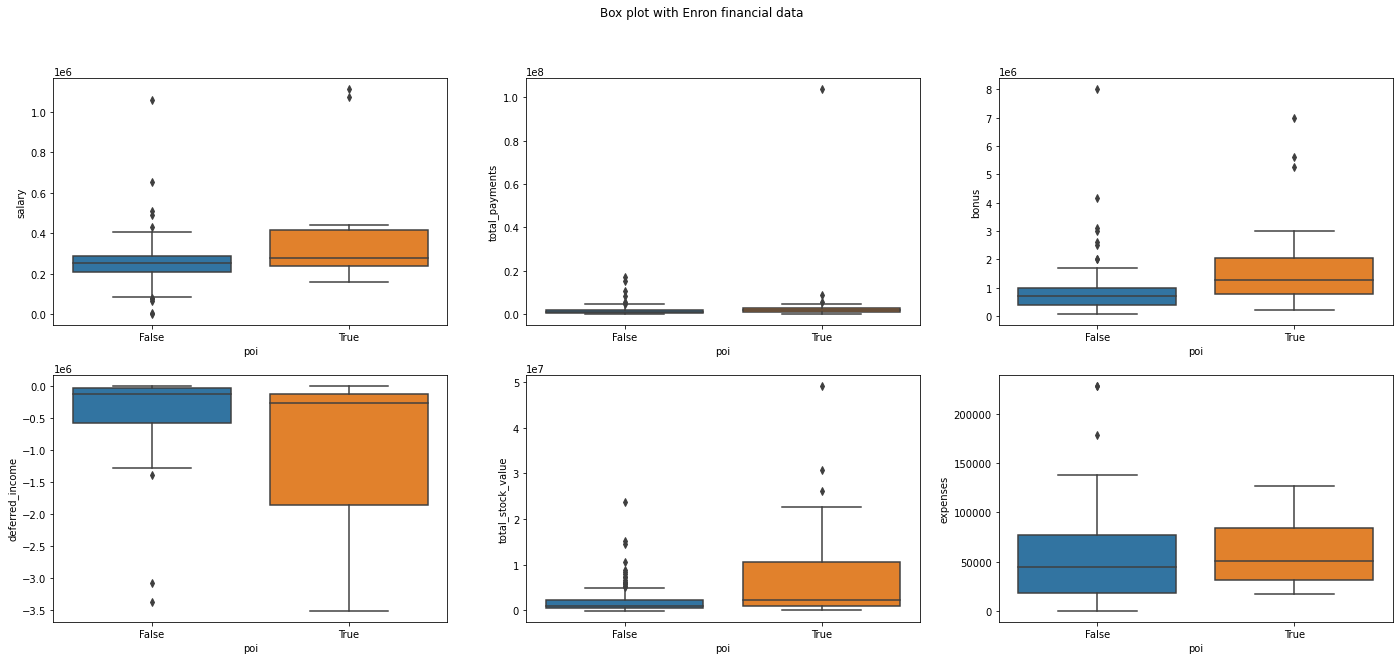

In [38]:

sns_boxplot(enron_df, 'Box plot with Enron financial data', financial_features, 2, 5)

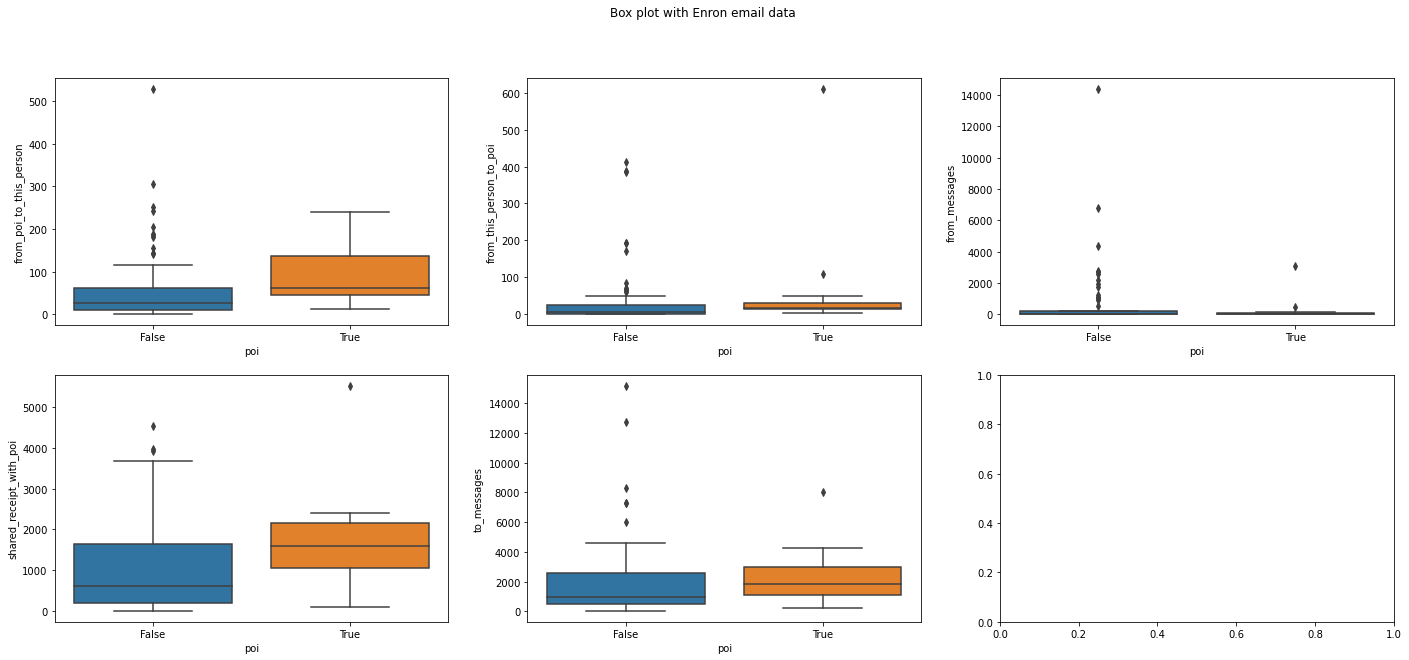

In [37]:
#--- Explore email features:

#--- Compare POI data vs non-POI data:
sns_boxplot(enron_df, 'Box plot with Enron email data', email_features, 2, 3)


<h2>Question 2</h2>

>
What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importance of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values. [relevant rubric items: “create new features”, “intelligently select features”, “properly scale features”]